<a href="https://colab.research.google.com/github/annien094/2D-3D-EP-PINNs/blob/master/predator_prey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/MyDrive/predator_prey_PINNs

# !pip install DeepXDE==0.10
!pip install deepXDE

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
/content/drive/MyDrive/predator_prey_PINNs
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00
Mon Sep 16 13:52:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8 

Compiling model...
Building feed-forward neural network...
'build' took 0.127067 s

'compile' took 1.861690 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.64e-01, 5.92e-01, 8.12e-01, 1.63e-01, 8.76e-03, 4.11e-02]    [9.88e-01, 5.91e-01, 8.09e-01, 1.63e-01, 8.76e-03, 4.11e-02]    []  
1000      [4.36e-03, 2.49e-03, 3.51e-03, 2.52e-05, 5.27e-06, 1.00e-05]    [4.26e-03, 2.40e-03, 3.54e-03, 2.52e-05, 5.27e-06, 1.00e-05]    []  
2000      [9.38e-04, 9.84e-04, 1.03e-03, 4.96e-06, 6.96e-06, 2.48e-06]    [9.18e-04, 9.68e-04, 1.05e-03, 4.96e-06, 6.96e-06, 2.48e-06]    []  
3000      [4.72e-04, 5.56e-04, 5.60e-04, 2.92e-06, 5.99e-06, 1.10e-06]    [4.63e-04, 5.39e-04, 5.62e-04, 2.92e-06, 5.99e-06, 1.10e-06]    []  
4000      [3.01e-04, 3.79e-04, 3.77e-04, 2.27e-06, 5.10e-06, 5.91e-07]    [3.01e-04, 3.62e-04, 3.77e-04, 2.27e-06, 5.10e-06, 5.91e-07]    []  
5000 

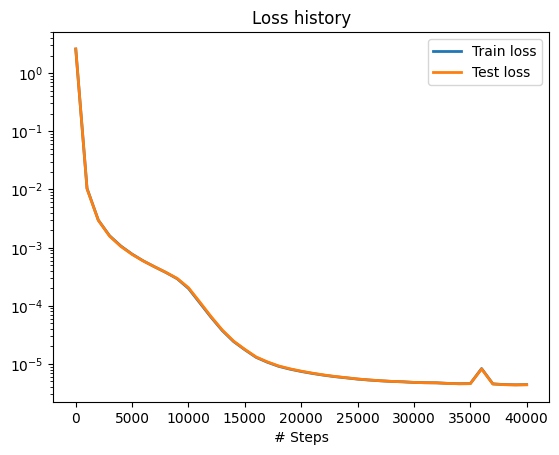

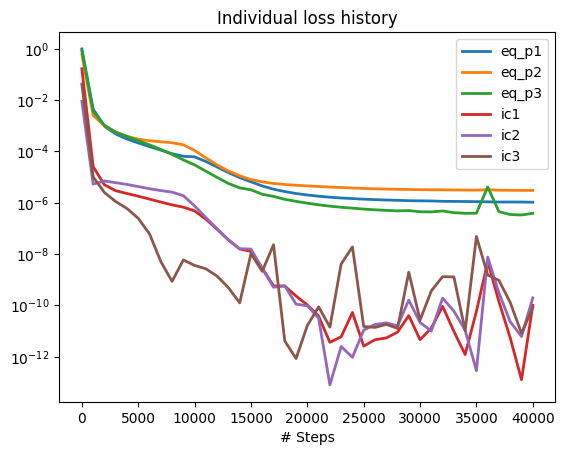

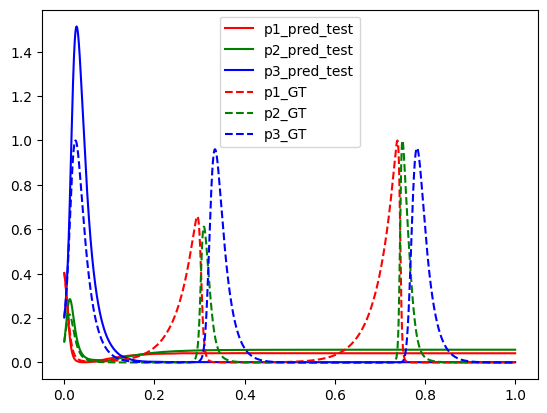

In [5]:
import sys
import os
import csv
from sklearn.model_selection import train_test_split
from deepxde.backend import tf
import matplotlib.pyplot as plt
import argparse
import numpy as np
import deepxde as dde # version 0.11 or higher
import scipy.io
from pandas import read_csv

## Network Parameters
input = 1 # network input size  # dimension of the X
num_hidden_layers = 3 # number of hidden layers for NN
hidden_layer_size = 32 # size of each hidden layers
output = 3 # network output size

## Training Parameters
num_domain = 6000 # number of training points within the domain
num_boundary = 3 # number of training boundary condition points on the geometry boundary
num_test = 3000 # number of testing points within the domain
epochs = 40000 # number of epochs for training
lr =  0.0001 # learning rate
test_size = 0.0001 # precentage of testing data

# Select training options
data = 2              # dataset '2' or '3'
loss_term = 'eq_only' # 'eq_only', 'data_only', or 'all'
scale = 'minmax'      # 'z-score' or 'minmax'
ini_con = 'soft'      # 'soft' or 'hard' initial conditions
fourier = True       # 'True' or 'False'

if data == 2:
  df = read_csv('P_t2.csv', header=None, delimiter=',')
  ic = [50, 10, 5]
  g1 = 0.25
  g2 = -0.2
  g3 = -0.5
  d12 = -0.04
  d13 = -0.04
  d21 = 0.04
  d23 = -0.02
  d31 = 0.02
  d32 = 0.04

elif data == 3:
  df = read_csv('P_t3.csv', header=None, delimiter=',')
  ic = [50, 20, 10]
  d12 = -0.1
  d21 = 0.075
  d23 = -0.05
  d32 = 0.02
  d13 = 0
  d31 = 0
  g1 = 1.5
  g2 = -1.0
  g3 = -0.5

dt = 0.002 # time step in the simulated data

observe_x = np.arange(start=0, stop=df.shape[0] * dt, step=dt).reshape(-1,1)/(df.shape[0]*dt) # scale time to [0,1]
p1 = df.iloc[:, 0].to_numpy().reshape(-1, 1)
p2 = df.iloc[:, 1].to_numpy().reshape(-1, 1)
p3 = df.iloc[:, 2].to_numpy().reshape(-1, 1)

# u = u[:len(u) // 5]
# v = v[:len(v) // 5]
# w = w[:len(w) // 5]
# observe_x = observe_x[:len(observe_x)//5]/0.2

def predator_prey_rescaled(x, y):
    p1 = y[:, 0:1]
    p2 = y[:, 1:2]
    p3 = y[:, 2:3]

    dp1_t = dde.grad.jacobian(y, x, i=0)
    dp2_t = dde.grad.jacobian(y, x, i=1)
    dp3_t = dde.grad.jacobian(y, x, i=2)

    eq_p1 = dp1_t / T - g1*p1 - d12*p1*p2*m_p2 - d13*p1*p3*m_p3
    eq_p2 = dp2_t / T - d21*p2*p1*m_p1 - g2*p2 - d23*p2*p3*m_p3
    eq_p3 = dp3_t / T - d31*p3*p1*m_p1 - d32*p3*p2*m_p2 - g3*p3

    return [eq_p1, eq_p2, eq_p3]

def predator_prey_normalised(x, y):
    p1 = y[:, 0:1] * sig1 + m_p1
    p2 = y[:, 1:2] * sig2 + m_p2
    p3 = y[:, 2:3] * sig3 + m_p3

    dp1_t = dde.grad.jacobian(y, x, i=0) * sig1 / T
    dp2_t = dde.grad.jacobian(y, x, i=1) * sig2 / T
    dp3_t = dde.grad.jacobian(y, x, i=2) * sig3 / T

    eq_p1 = dp1_t - g1*p1 - d12*p1*p2 - d13*p1*p3
    ep_p2 = dp2_t - d21*p2*p1 - g2*p2 - d23*p2*p3
    eq_p3 = dp3_t - d31*p3*p1 - d32*p3*p2 - g3*p3

    return [eq_p1, ep_p2, eq_p3]

# Normalise/scale the inputs

if scale == 'minmax':
  m_p1 = p1.max()
  m_p2 = p2.max()
  m_p3 = p3.max()

  p1 = p1 / m_p1
  p2 = p2 / m_p2
  p3 = p3 / m_p3
  predator_prey_eq = predator_prey_rescaled

elif scale == 'z-score':
  m_p1 = p1.mean()
  m_p2 = p2.mean()
  m_p3 = p3.mean()

  sig1 = p1.std()
  sig2 = p2.std()
  sig3 = p3.std()

  p1 = (p1 - m_p1) / sig1
  p2 = (p2 - m_p2) / sig2
  p3 = (p3 - m_p3) / sig3
  predator_prey_eq = predator_prey_normalised

T = df.shape[0] * dt

## Split data to train and test
observe_train, observe_test, p1_train, p1_test, p2_train, p2_test, p3_train, p3_test=\
                           train_test_split(observe_x, p1, p2, p3, test_size=test_size, random_state=123)

def output_transform(t, y):
    t = t*T
    if scale == 'minmax':
      p1 = y[:, 0:1] * m_p1
      p2 = y[:, 1:2] * m_p2
      p3 = y[:, 2:3] * m_p3

      p1_t0 = ic[0] / m_p1
      p2_t0 = ic[1] / m_p2
      p3_t0 = ic[2] / m_p3

    elif scale == 'z-score':
      p1 = y[:, 0:1] * sig1 + m_p1
      p2 = y[:, 1:2] * sig2 + m_p2
      p3 = y[:, 2:3] * sig3 + m_p3

      p1_t0 = ( ic[0] - m_p1 ) / sig1
      p2_t0 = ( ic[1] - m_p2 ) / sig2
      p3_t0 = ( ic[2] - m_p3 ) / sig3

    return tf.concat(
        [p1 * tf.tanh(t) + p1_t0, p2 * tf.tanh(t) + p2_t0, p3 * tf.tanh(t) + p3_t0], axis=1
    )

def input_transform(t):
    t = t*T
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t)
        ),
        axis=1,
    )

def predator_prey(x, y):
    p1 = y[:, 0:1]
    p2 = y[:, 1:2]
    p3 = y[:, 2:3]

    dp1_t = dde.grad.jacobian(y, x, i=0)
    dp2_t = dde.grad.jacobian(y, x, i=1)
    dp3_t = dde.grad.jacobian(y, x, i=2)

    eq_p1 = dp1_t - g1*p1 - d12*p1*p2 - d13*p1*p3
    eq_p2 = dp2_t - d21*p2*p1 - g2*p2 - d23*p2*p3
    eq_p3 = dp3_t - d31*p3*p1 - d32*p3*p2 - g3*p3

    # eq_p1 = dp1_t / T - g1*p1 - d12*p1*p2*m_p2 - d13*p1*p3*m_p3
    # eq_p2 = dp2_t / T  - d21*p2*p1*m_p1 - g2*p2 - d23*p2*p3*m_p3
    # eq_p3 = dp3_t / T  - d31*p3*p1*m_p1 - d32*p3*p2*m_p2 - g3*p3

    return [eq_p1, eq_p2, eq_p3]


## Model observed data
observe_p1 = dde.PointSetBC(observe_train, p1_train, component=0)
observe_p2 = dde.PointSetBC(observe_train, p2_train, component=1)
observe_p3 = dde.PointSetBC(observe_train, p3_train, component=2)

# geom = dde.geometry.TimeDomain(0.0, 50000.0)
geom = dde.geometry.TimeDomain(0.0, 1.0)

def boundary(_, on_initial):
    return on_initial

if scale == 'minmax':
  ic1 = dde.icbc.IC(geom, lambda x: ic[0] / m_p1, boundary, component=0)
  ic2 = dde.icbc.IC(geom, lambda x: ic[1] / m_p2, boundary, component=1)
  ic3 = dde.icbc.IC(geom, lambda x: ic[2] / m_p3, boundary, component=2)
elif scale == 'z-score':
  ic1 = dde.icbc.IC(geom, lambda x: (ic[0]-m_p1)/sig1, boundary, component=0)
  ic2 = dde.icbc.IC(geom, lambda x: (ic[1]-m_p2)/sig2, boundary, component=1)
  ic3 = dde.icbc.IC(geom, lambda x: (ic[2]-m_p3)/sig3, boundary, component=2)

# Assign input data and labels for loss history plot based on the training options selected
if loss_term == 'data_only' and ini_con == 'hard':
  input_data = [observe_p1, observe_p2, observe_p3]
  loss_label = ['data_p1', 'data_p2','data_p3']
elif loss_term == 'data_only' and ini_con == 'soft':
  input_data = [ic1, ic2, ic3, observe_p1, observe_p2, observe_p3]
  loss_label = ['ic1','ic2','ic3', 'data_p1', 'data_p2','data_p3']
elif loss_term == 'eq_only' and ini_con == 'hard':
  input_data = []
  loss_label = ['eq_p1', 'eq_p2', 'eq_p3']
elif loss_term == 'eq_only' and ini_con == 'soft':
  input_data = [ic1, ic2, ic3]
  loss_label = ['eq_p1', 'eq_p2', 'eq_p3', 'ic1','ic2','ic3']
elif loss_term == 'all' and ini_con == 'hard':
  input_data = [observe_p1, observe_p2, observe_p3]
  loss_label = ['eq_p1', 'eq_p2', 'eq_p3', 'data_p1', 'data_p2','data_p3']
elif loss_term == 'all' and ini_con == 'soft':
  input_data = [ic1, ic2, ic3, observe_p1, observe_p2, observe_p3]
  loss_label = ['eq_p1', 'eq_p2', 'eq_p3', 'ic1','ic2','ic3', 'data_p1', 'data_p2','data_p3']

## Define the Network
pde = predator_prey
net = dde.maps.FNN([input] + [hidden_layer_size] * num_hidden_layers + [output], "tanh", "Glorot uniform")
if ini_con == 'hard':
  net.apply_output_transform(output_transform)

if fourier:
  net.apply_feature_transform(input_transform)

pde_data = dde.data.PDE(geom, predator_prey_eq, input_data,
                        num_domain = num_domain,
                        num_boundary=num_boundary,
                        train_distribution='uniform',
                        anchors=observe_train,
                        num_test=num_test)
model = dde.Model(pde_data, net)
model.compile("adam", lr=lr)

## Train Network
losshistory, train_state = model.train(epochs=epochs, display_every=1000)

# # Plot loss history (summed total loss)
loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)
plt.figure()
plt.semilogy(losshistory.steps, loss_train, label="Train loss", linewidth=2)
plt.semilogy(losshistory.steps, loss_test, label="Test loss", linewidth=2)
plt.title("Loss history")
for i in range(len(losshistory.metrics_test[0])):
    plt.semilogy(
        losshistory.steps,
        np.array(losshistory.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("# Steps")
plt.legend()
plt.savefig("Loss history run ")
# Plot individual loss term history
plt.figure()
plt.semilogy(losshistory.steps, losshistory.loss_train, label=loss_label, linewidth=2)

plt.title("Individual loss history")
plt.xlabel("# Steps")
plt.legend()
plt.savefig("Individual loss history run")
print("calculating RMSE")

## Compute rMSE for testing data & all (training + testing)
p1_pred_test = model.predict(observe_test)[:,0:1]
rmse_p1_test = np.sqrt(np.square(p1_pred_test - p1_test).mean())
p2_pred_test = model.predict(observe_test)[:,1:2]
rmse_p2_test = np.sqrt(np.square(p2_pred_test - p2_test).mean())
p3_pred_test = model.predict(observe_test)[:,2:3]
rmse_p3_test = np.sqrt(np.square(p3_pred_test - p3_test).mean())
print(f"RMSE p1: {rmse_p1_test:.4f}")
print(f"RMSE p2: {rmse_p2_test:.4f}")
print(f"RMSE p3: {rmse_p3_test:.4f}")

p1_pred=model.predict(observe_x)[:,0:1]
p2_pred=model.predict(observe_x)[:,1:2]
p3_pred=model.predict(observe_x)[:,2:3]

# Plot
plt.figure()
plt.plot(observe_x, p1_pred, color='red', label="p1_pred_test")
plt.plot(observe_x, p2_pred, color='green', label="p2_pred_test")
plt.plot(observe_x, p3_pred, color='blue', label="p3_pred_test")
plt.plot(observe_x, p1,'--', color='red', label='p1_GT')
plt.plot(observe_x, p2,'--', color='green', label='p2_GT')
plt.plot(observe_x, p3,'--', color='blue', label='p3_GT')
if loss_term != 'eq_only':
  plt.plot(observe_train, p1_train, 'x', color='black', markersize=1, label='train_data_p1')
  plt.plot(observe_train, p2_train, 'x', color='black', markersize=1, label='train_data_p2')
  plt.plot(observe_train, p3_train, 'x', color='black', markersize=1, label='train_data_p3')
plt.legend()

Compiling model...
Building feed-forward neural network...
'build' took 0.651552 s

'compile' took 2.565369 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.95e+02, 7.15e+00]    [1.95e+02, 7.16e+00]    []  
1000      [3.97e+00, 1.32e+00]    [3.87e+00, 1.31e+00]    []  
2000      [1.32e+00, 6.83e-01]    [1.24e+00, 6.68e-01]    []  
3000      [2.01e+00, 7.60e-01]    [1.94e+00, 7.56e-01]    []  
4000      [1.63e+00, 6.28e-01]    [1.56e+00, 6.22e-01]    []  
5000      [1.42e+00, 5.77e-01]    [1.36e+00, 5.69e-01]    []  
6000      [1.25e+00, 5.25e-01]    [1.18e+00, 5.16e-01]    []  
7000      [1.08e+00, 4.85e-01]    [1.02e+00, 4.74e-01]    []  
8000      [9.10e-01, 4.59e-01]    [8.57e-01, 4.46e-01]    []  
9000      [7.36e-01, 4.17e-01]    [6.93e-01, 4.05e-01]    []  
10000     [5.47e-01, 3.50e-01]    [5.15e-01, 3.39e-01]    []  
11000     [3.62e-01, 2.73e-01]    [3.42e-01, 2.63e-01]    []  
12000     [2.41e-01, 2.35e-01]    [2.27e-01,

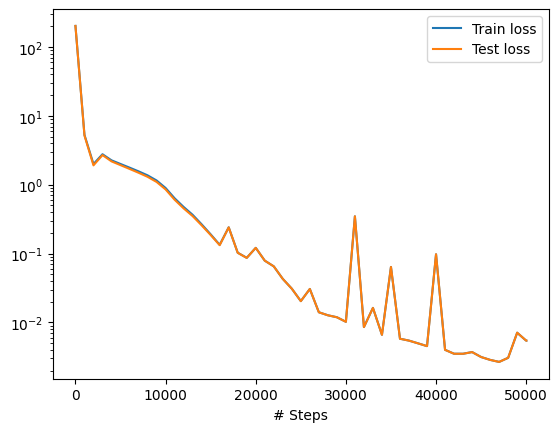

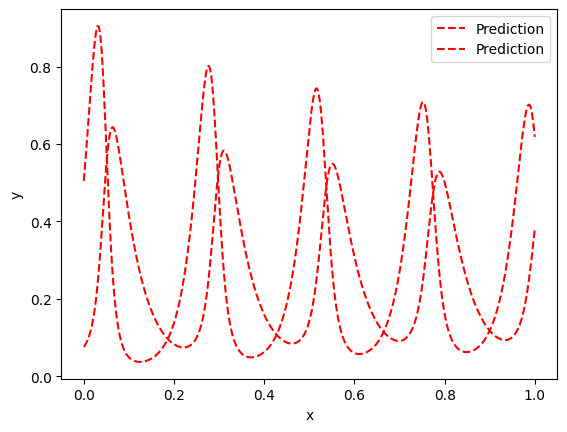

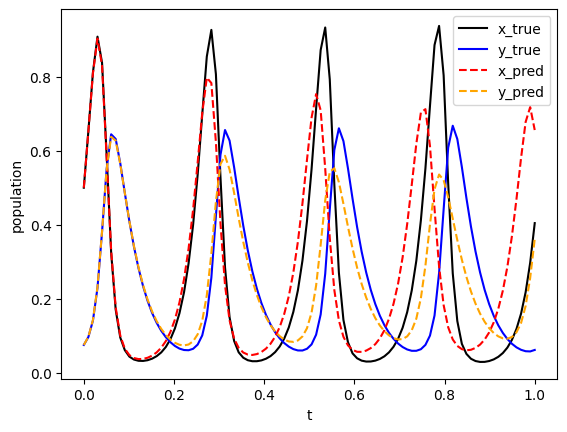

In [6]:
### Example Lokta Volterra on DeepXDE
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle, jax"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch
# Import paddle if using backend paddle
# import paddle
# Import jax.numpy if using backend jax
# import jax.numpy as jnp

ub = 200
rb = 20


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):
    # Most backends
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # r = y_val[:, 0:1]
    # p = y_val[:, 1:2]
    # dr_t, _ = dde.grad.jacobian(y, x, i=0)
    # dp_t, _ = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Backend tensorflow.compat.v1 or tensorflow
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )
# Backend pytorch
# def input_transform(t):
#     return torch.cat(
#         [
#             torch.sin(t),
#         ],
#         dim=1,
#     )
# Backend paddle
# def input_transform(t):
#     return paddle.concat(
#         (
#             paddle.sin(t),
#         ),
#         axis=1,
#     )
# Backend jax
# def input_transform(t):
#     if t.ndim == 1:
#         t = t[None]
#
#     return jnp.concatenate(
#         [
#             jnp.sin(t),
#         ],
#         axis=1
#     )

# hard constraints: x(0) = 100, y(0) = 15
# Backend tensorflow.compat.v1 or tensorflow
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)
# Backend pytorch
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return torch.cat([y1 * torch.tanh(t) + 100 / ub, y2 * torch.tanh(t) + 15 / ub], dim=1)
# Backend paddle
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return paddle.concat([y1 * paddle.tanh(t) + 100 / ub, y2 * paddle.tanh(t) + 15 / ub], axis=1)
# Backend jax
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return jnp.concatenate(
#         [y1 * jnp.tanh(t) + 100 / ub, y2 * jnp.tanh(t) + 15 / ub],
#         axis=1
#     ).squeeze()

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)
# Most backends except jax can have a second fine tuning of the solution
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()